In [1]:
import pandas as pd
import pickle
#import torch
#import transformers
#from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from src.preprocess import *
from src.models import *
from src.lib import *

## Explore data

In [2]:
import numpy as np
import pandas as pd

## Training and Testing files
read_file=pd.read_csv('./data/IntentSDCNL_Training.csv', encoding = "ISO-8859-1")
read_file1=pd.read_csv('./data/IntentSDCNL_Testing.csv', encoding = "ISO-8859-1")



#training data
df_train=pd.DataFrame(read_file,columns= ['selftext','ANNOTATIONS'])### 
df_train = df_train.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_train= df_train.convert_dtypes()

#testing data
df_test=pd.DataFrame(read_file1,columns= ['selftext','ANNOTATIONS'])#### 
df_test = df_test.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_test= df_test.convert_dtypes()

## Sampling file
df_samples=pd.read_csv('./data/sample.csv', encoding = "ISO-8859-1")

## add samples to training file

frame = [df_train, df_samples]
df_train =  pd.concat(frame)

In [3]:
## some preprocessings due to wrong entries
df_test.drop(df_test[df_test.text=="emptypost"].index, inplace=True)
df_train.drop(df_train[df_train.text=="emptypost"].index, inplace=True)
df_test.drop(df_test[df_test.label==" "].index, inplace=True)
df_train.drop(df_train[df_train.label==" "].index, inplace=True)
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817 entries, 0 to 359
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1817 non-null   object
 1   label   1817 non-null   Int64 
dtypes: Int64(1), object(1)
memory usage: 44.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817 entries, 0 to 359
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1817 non-null   object
 1   label   1817 non-null   Int64 
dtypes: Int64(1), object(1)
memory usage: 44.4+ KB


###### Class distribution of training data #####
###### Class distribution of training data #####


<AxesSubplot:ylabel='label'>

<AxesSubplot:ylabel='label'>

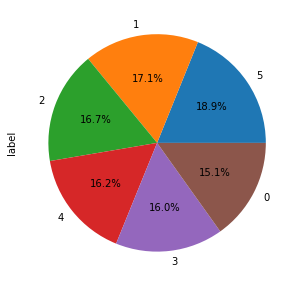

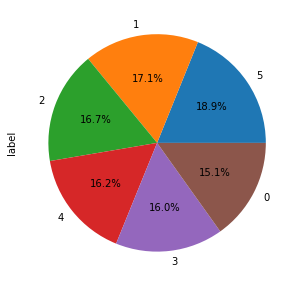

In [5]:
import matplotlib.pyplot as plt
print("###### Class distribution of training data #####")
#labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_train['label'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)




###### Class distribution of testing data 
 #####
###### Class distribution of testing data 
 #####


<AxesSubplot:ylabel='label'>

<AxesSubplot:ylabel='label'>

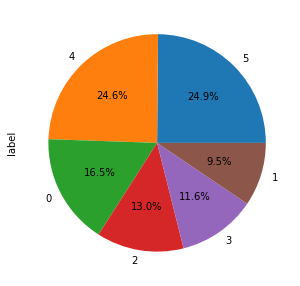

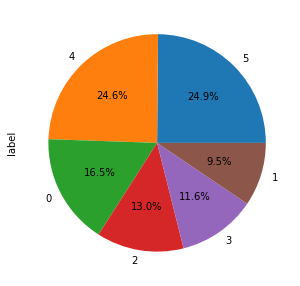

In [6]:

print("###### Class distribution of testing data \n #####")
#labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_test['label'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)


In [7]:
df_test['label'].value_counts()

5    92
4    91
0    61
2    48
3    43
1    35
Name: label, dtype: Int64

5    92
4    91
0    61
2    48
3    43
1    35
Name: label, dtype: Int64

In [8]:
frame = [df_test, df_train]
data =  pd.concat(frame)
data

,text,label
0,"Indubitably, I am not worth anything as a bein...",1
1,"Almost everyday I wake up hating myself, why w...",5
2,To kill myself if im ugly?,1
3,God help me.... I know I should go to the hosp...,1
4,I really don't want to do anything anymore. Wh...,2
...,...,...
355,IÃ¢ÂÂve posted here a lot over the last year...,3
356,JUst need to ramble a little. Over 30 years of...,2
357,I think the relationship btw money and ur ment...,2
358,Hi everyone. I just wanted to clear something ...,3


,text,label
0,"Indubitably, I am not worth anything as a bein...",1
1,"Almost everyday I wake up hating myself, why w...",5
2,To kill myself if im ugly?,1
3,God help me.... I know I should go to the hosp...,1
4,I really don't want to do anything anymore. Wh...,2
...,...,...
355,IÃ¢ÂÂve posted here a lot over the last year...,3
356,JUst need to ramble a little. Over 30 years of...,2
357,I think the relationship btw money and ur ment...,2
358,Hi everyone. I just wanted to clear something ...,3


#### A Sample

In [9]:
print_plot(df_train,0)

i have been so depressed these past couple weeks ever since i got back from vacation normal life and reality has hit me and its terrible. im 19 i havent moved out yet i dont really have a sufficient job i have one but its not enough money for me to support myself. at least i have a car and im taking online classes so. i feel stuck in this stupid fucking town. empty and alone man i just want someone to love me dude but im ugly and fat and worthless and no one is ever going to see im worth the chance. its just one thing after another to worry about. why not end it now before i really fuck up and become miserable? i dont see the point in going on im just really down right now i dont know what to do )): all there is darkness idk how to get out of this hole i hate myself i hate my body i hate my life i dont think it will ever get better
text: 1
i have been so depressed these past couple weeks ever since i got back from vacation normal life and reality has hit me and its terrible. im 19 i ha

## Clean and preprocess the text

####  Clean Training and Testing data

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


#training data
df_train = df_train.reset_index(drop=True)
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] = df_train['text'].apply(clean_text)
##testing data
df_train = df_train.reset_index(drop=True)
df_test['text'] = df_test['text'].apply(clean_text)
df_test['text'] = df_test['text'].str.replace('\d+', '')

/var/folders/36/14vf2r1n2q92gt0lb6xj29nm0000gn/T/ipykernel_16645/1264519194.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['text'] = df_test['text'].str.replace('\d+', '')
/var/folders/36/14vf2r1n2q92gt0lb6xj29nm0000gn/T/ipykernel_16645/1264519194.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['text'] = df_test['text'].str.replace('\d+', '')


#### A sample after cleanup

In [11]:
print_plot(df_train,0)

depressed past couple weeks ever since got back vacation normal life reality hit terrible im 19 havent moved yet dont really sufficient job one enough money support least car im taking online classes feel stuck stupid fucking town empty alone man want someone love dude im ugly fat worthless one ever going see im worth chance one thing another worry end really fuck become miserable dont see point going im really right dont know darkness idk get hole hate hate body hate life dont think ever get better
text: 1
depressed past couple weeks ever since got back vacation normal life reality hit terrible im 19 havent moved yet dont really sufficient job one enough money support least car im taking online classes feel stuck stupid fucking town empty alone man want someone love dude im ugly fat worthless one ever going see im worth chance one thing another worry end really fuck become miserable dont see point going im really right dont know darkness idk get hole hate hate body hate life dont thin

#### Intialize parameters

In [12]:
# Define some Global Variables
max_nb_words = 60000
max_features = 10543 # Maximum Number of words we want to include in our dictionary
maxlen = 500 # No of words in question we want to create a sequence with
emb_dim = 100# Size of word to vec embedding we are usingtokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)


#### Initial Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)# tokenizer on whole training and testing data
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14692 unique tokens.
Found 14692 unique tokens.


In [14]:
X_train = tokenizer.texts_to_sequences(df_train['text'].values)
X_train = pad_sequences(X_train, maxlen=maxlen)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (1817, 500)
Shape of data tensor: (1817, 500)


In [15]:
Y_train = pd.get_dummies(df_train['label']).values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (1817, 6)
Shape of label tensor: (1817, 6)


In [16]:
X_test = tokenizer.texts_to_sequences(df_test['text'].values)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (370, 500)
Shape of data tensor: (370, 500)


In [17]:
Y_test = pd.get_dummies(df_test['label']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (370, 6)
Shape of label tensor: (370, 6)


### Finally some validation data from Training Data

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,random_state=0,test_size=0.1)

In [19]:
print('TrainingData',X_train.shape,Y_train.shape)
print('TestingData',X_test.shape,Y_test.shape)
print('ValidationData',X_val.shape,Y_val.shape)


TrainingData (1635, 500) (1635, 6)
TestingData (370, 500) (370, 6)
ValidationData (182, 500) (182, 6)
TrainingData (1635, 500) (1635, 6)
TestingData (370, 500) (370, 6)
ValidationData (182, 500) (182, 6)


In [20]:
#print a test sample
print('test example:', X_test[100])

test example: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [21]:
 len(X_test[100])

500

500

#### Intialize Embedding

In [22]:
embedding_vectors = {}

with open('./embeddings/glove.6B.100d.txt','r',encoding='utf-8') as file:

    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   

Size of vocabulary in GloVe: 400000
Size of vocabulary in GloVe: 400000


In [23]:
#initialize the embedding_matrix with zeros
emb_dim = 100
if max_nb_words is not None: 
    vocab_len = max_nb_words
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#Check some of the out of vocabulary words
print(f'A few out of valubulary words: {oov_words[0:5]}')

A few out of valubulary words: ["i'm", "don't", "i've", "can't", "it's"]
A few out of valubulary words: ["i'm", "don't", "i've", "can't", "it's"]


In [24]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

3015 out of 60000 words were OOV.
3015 out of 60000 words were OOV.


## NN models

In [25]:
##Global variables
batch_size = 256
epochs  = 20

### a) LSTM Model

In [26]:
lstm_model = LSTM_model(embedding_matrix,vocab_len,emb_dim)

2022-01-08 13:43:48.128516: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-08 13:43:48.128516: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         6000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 6,118,022
Trainable params: 118,022
Non-trainable params: 6,000,000
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Emb

#### Train the model

In [28]:
%%time
history = lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

Epoch 1/5
Epoch 1/5
7/7 [==============================] - 12s 1s/step - loss: 1.8192 - accuracy: 0.1670 - val_loss: 1.7765 - val_accuracy: 0.2198
Epoch 2/5
Epoch 2/5
7/7 [==============================] - 11s 2s/step - loss: 1.7795 - accuracy: 0.2018 - val_loss: 1.7731 - val_accuracy: 0.1923
Epoch 3/5
Epoch 3/5
7/7 [==============================] - 16s 2s/step - loss: 1.7640 - accuracy: 0.2245 - val_loss: 1.7564 - val_accuracy: 0.2033
Epoch 4/5
Epoch 4/5
7/7 [==============================] - 11s 2s/step - loss: 1.7386 - accuracy: 0.2477 - val_loss: 1.7320 - val_accuracy: 0.2527
Epoch 5/5
Epoch 5/5
7/7 [==============================] - 15s 2s/step - loss: 1.6885 - accuracy: 0.3046 - val_loss: 1.6238 - val_accuracy: 0.3571
CPU times: user 1min 47s, sys: 25.3 s, total: 2min 12s
Wall time: 1min 5s
CPU times: user 1min 47s, sys: 25.3 s, total: 2min 12s
Wall time: 1min 5s


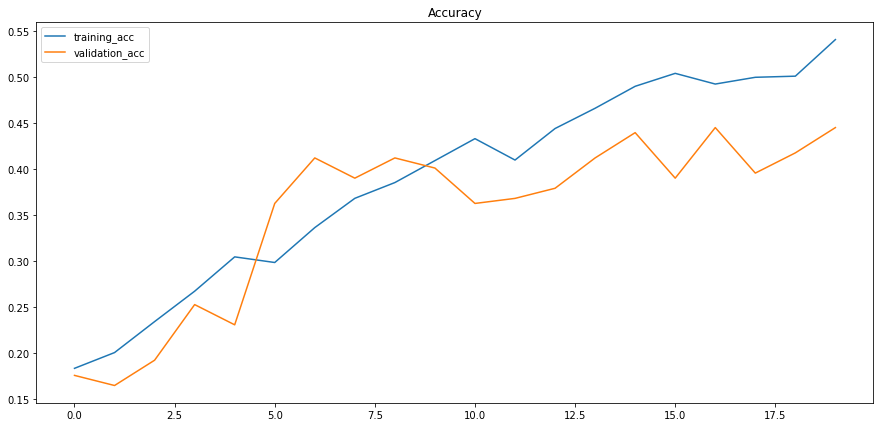

In [29]:
#plot accuracy
plot_accuracy(history,epochs)

In [29]:
# Accuracy
train_test_accuracy(lstm_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 36.76
Test accuracy: 38.11
Train accuracy: 36.76
Test accuracy: 38.11


In [30]:
#Classification report
report_nn(lstm_model,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.50      0.61      0.55        61
           1       0.40      0.11      0.18        35
           2       0.30      0.56      0.39        48
           3       0.19      0.16      0.18        43
           4       0.45      0.38      0.41        91
           5       0.37      0.34      0.35        92

    accuracy                           0.38       370
   macro avg       0.37      0.36      0.34       370
weighted avg       0.39      0.38      0.37       370

accuracy: 0.381
              precision    recall  f1-score   support

           0       0.50      0.61      0.55        61
           1       0.40      0.11      0.18        35
           2       0.30      0.56      0.39        48
           3       0.19      0.16      0.18        43
           4       0.45      0.38      0.41        91
           5       0.37      0.34      0.35        92

    accuracy                           0.38       370
   macr

### b) CNN

In [ ]:
cnn_model=CNN_model(embedding_matrix,vocab_len,emb_dim)

#### Train the model

In [ ]:
%%time
history = cnn_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),batch_size = batch_size, epochs = epochs)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(cnn_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_model,X_test,Y_test)

### d) GRU

In [ ]:
gru_model = GRU_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
## tranining
%%time
history = gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(gru_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(gru_model,X_test,Y_test)


## e) CNN+GRU

In [ ]:
cnn_gru_model =CNN_GRU_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
## tranining
%%time
history=cnn_gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(cnn_gru_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_gru_model,X_test,Y_test)

### f) CNN+LSTM

In [ ]:
cnn_lstm_model = CNN_LSTM_model(embedding_matrix,vocab_len,emb_dim)

In [103]:
## tranining
%%time
history=cnn_lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

Epoch 1/25
7/7 [==============================] - 16s 2s/step - loss: 1.7746 - accuracy: 0.2183 - val_loss: 1.7336 - val_accuracy: 0.2473
Epoch 2/25
7/7 [==============================] - 11s 2s/step - loss: 1.7192 - accuracy: 0.2550 - val_loss: 1.6896 - val_accuracy: 0.2802
Epoch 3/25
7/7 [==============================] - 16s 2s/step - loss: 1.6660 - accuracy: 0.2936 - val_loss: 1.6104 - val_accuracy: 0.3462
Epoch 4/25
7/7 [==============================] - 13s 2s/step - loss: 1.6132 - accuracy: 0.3284 - val_loss: 1.5845 - val_accuracy: 0.3407
Epoch 5/25
7/7 [==============================] - 13s 2s/step - loss: 1.5725 - accuracy: 0.3621 - val_loss: 1.6001 - val_accuracy: 0.3242
Epoch 6/25
7/7 [==============================] - 14s 2s/step - loss: 1.5185 - accuracy: 0.4024 - val_loss: 1.5440 - val_accuracy: 0.4066
Epoch 7/25
7/7 [==============================] - 12s 2s/step - loss: 1.4281 - accuracy: 0.4495 - val_loss: 1.5644 - val_accuracy: 0.4066
Epoch 8/25
7/7 [==================

In [104]:
#plot accuracy
plot_accuracy(history)

Train accuracy: 70.21
Test accuracy: 47.84


In [105]:
# Accuracy
train_test_accuracy(cnn_lstm_model,X_train,Y_train,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.54      0.54      0.54        61
           1       0.18      0.29      0.22        35
           2       0.45      0.69      0.54        48
           3       0.59      0.40      0.47        43
           4       0.57      0.52      0.54        91
           5       0.55      0.40      0.47        92

    accuracy                           0.48       370
   macro avg       0.48      0.47      0.46       370
weighted avg       0.51      0.48      0.48       370

accuracy: 0.478


In [ ]:
#Classification report
report_nn(cnn_lstm_model,X_test,Y_test)

##### Confusion Matrix

--Confusion Matrix for CNN+LSTM--


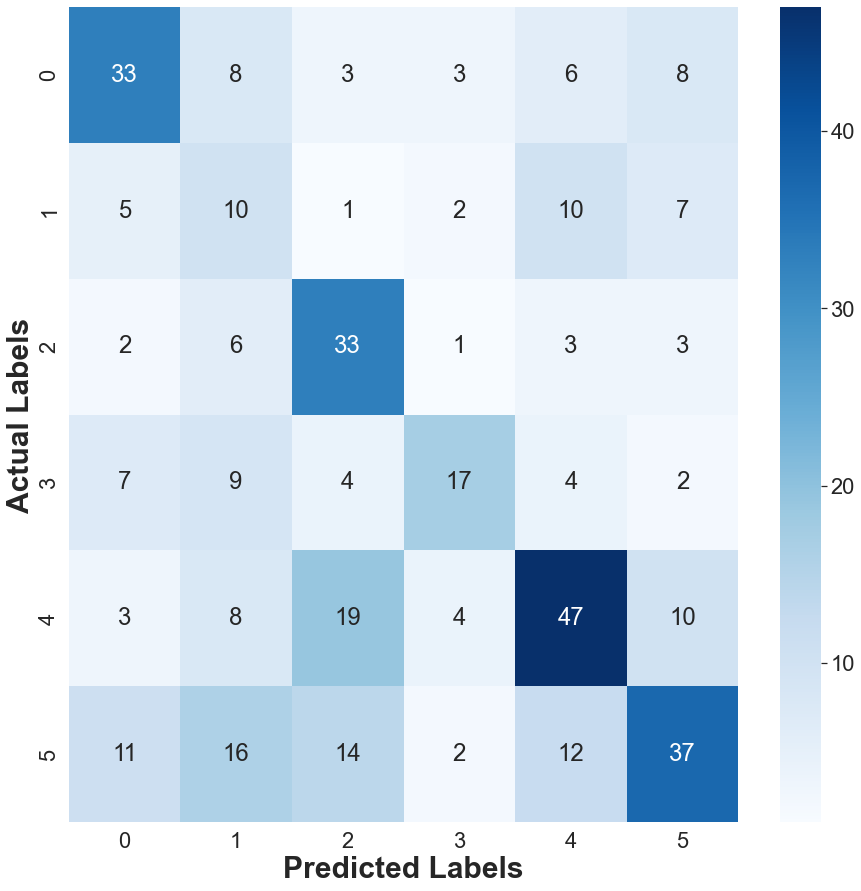

In [107]:
#cnn_lstm_model0=cnn_lstm_model
print('--Confusion Matrix for CNN+LSTM--')
print_confusion(cnn_lstm_model,X_test,Y_test)

## Bidirectional LSTM

In [ ]:
lstmbd_model = BID_LSTM_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
## tranining
%%time
history=lstmbd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(cnn_lstm_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_lstm_model,X_test,Y_test)

## Bidirectional GRU

In [ ]:
grubd_model = BID_GRU_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
## tranining
%%time
history=grubd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(grubd_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(grubd_model,X_test,Y_test)